Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StanModels
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_s("..", "scripts", "05")
cd(ProjDir)

### snippet 5.1

In [3]:
wd = CSV.read(rel_path("..", "data", "WaffleDivorce.csv"), delim=';')
df = convert(DataFrame, wd);
mean_ma = mean(df[:MedianAgeMarriage])
df[:MedianAgeMarriage_s] = convert(Vector{Float64},
  (df[:MedianAgeMarriage]) .- mean_ma)/std(df[:MedianAgeMarriage]);
first(df, 5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s
,String⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.60629
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.0,-0.686699
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.0,-0.204241
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5,1.22,41,1,111115,435450,0.26,-1.41039
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.0,0.599857


Define the Stan language model

In [4]:
ad_model = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] divorce; // Predictor
 vector[N] median_age; // Outcome
}

parameters {
 real a; // Intercept
 real bA; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
  # priors
  a ~ normal(10, 10);
  bA ~ normal(0, 1);
  sigma ~ uniform(0, 10);
  # model
  divorce ~ normal(a + bA*median_age , sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [5]:
stanmodel = Stanmodel(name="MedianAgeDivorce", monitors = ["a", "bA", "sigma"],
  model=ad_model, output_format=:mcmcchain);
# Input data for cmdstan
maddata = Dict("N" => length(df[:Divorce]), "divorce" => df[:Divorce],
    "median_age" => df[:MedianAgeMarriage_s]);
# Sample using cmdstan
rc, chn, cnames = stan(stanmodel, maddata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


File /Users/rob/.julia/dev/StanModels/scripts/05/tmp/MedianAgeDivorce.stan will be updated.

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE          MCSE         ESS
    a  9.6868905 0.20903440 0.0033051241 3.15088451674×10⁻³ 1000
   bA -1.0381688 0.20889146 0.0033028640 3.18306240299×10⁻³ 1000
sigma  1.5135236 0.15803332 0.0024987261 3.08660176878×10⁻³ 1000

Quantiles:
         2.5%       25.0%     50.0%      75.0%       97.5%  
    a  9.2729472  9.5424475  9.689060  9.83093000 10.0859100
   bA -1.4467963 -1.1780275 -1.034075 -0.89882125 -0.6302576
sigma  1.2445030  1.4011175  1.503840  1.61160750  1.8547233



Plot the density of posterior draws

┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.

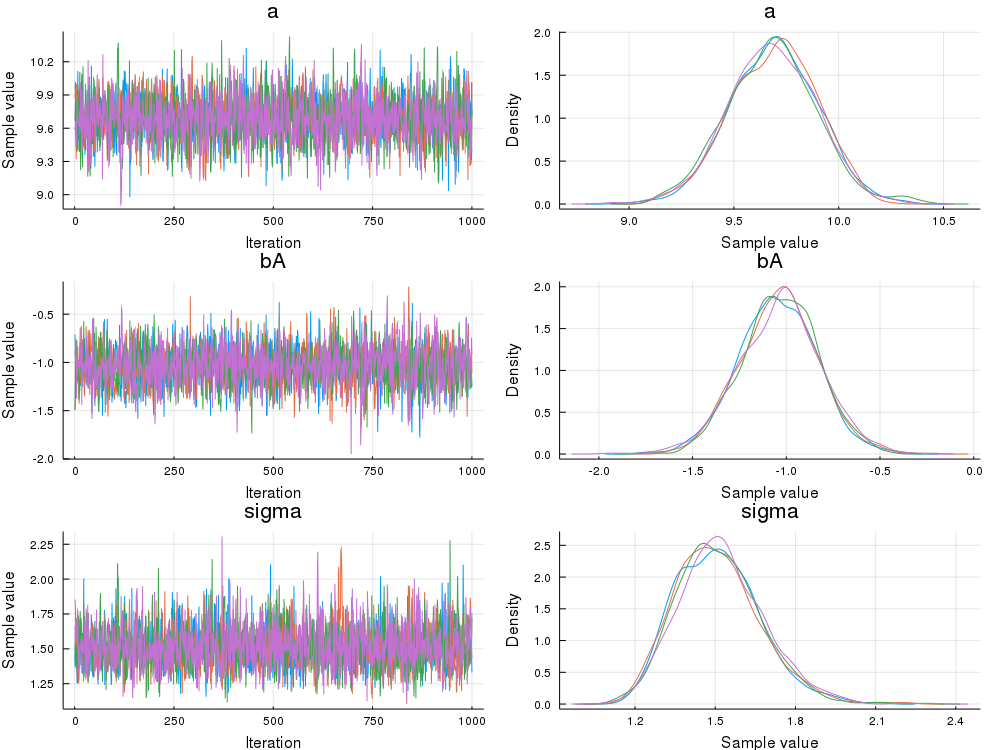

In [6]:
plot(chn)

Result rethinking

In [7]:
rethinking = "
       mean   sd  5.5% 94.5% n_eff Rhat
a      9.69 0.22  9.34 10.03  2023    1
bA    -1.04 0.21 -1.37 -0.71  1882    1
sigma  1.51 0.16  1.29  1.79  1695    1
"

"\n       mean   sd  5.5% 94.5% n_eff Rhat\na      9.69 0.22  9.34 10.03  2023    1\nbA    -1.04 0.21 -1.37 -0.71  1882    1\nsigma  1.51 0.16  1.29  1.79  1695    1\n"

Plot regression line using means and observations

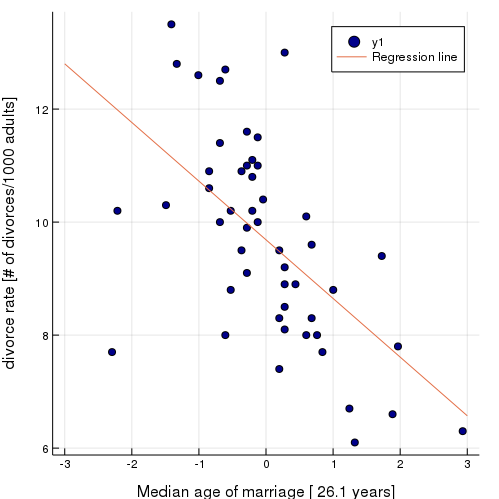

In [8]:
xi = -3.0:0.01:3.0
rws, vars, chns = size(chn[:, 1, :])
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df[:MedianAgeMarriage_s], df[:Divorce], color=:darkblue,
  xlab="Median age of marriage [ $(round(mean_ma, digits=1)) years]",
  ylab="divorce rate [# of divorces/1000 adults]")
plot!(xi, yi, lab="Regression line")

shade(), abline() and link()

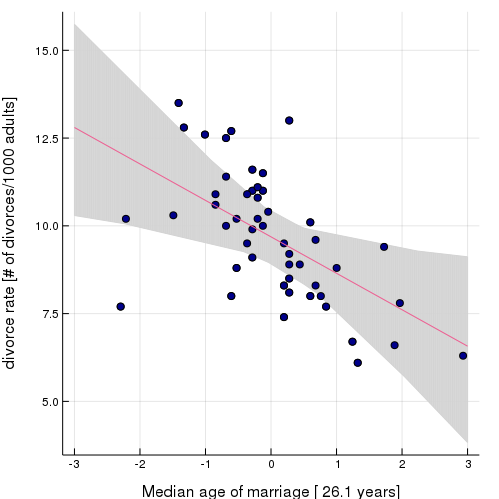

In [9]:
mu = link(xi, chn, [1, 2], mean(xi));
yl = [minimum(mu[i]) for i in 1:length(xi)];
yh =  [maximum(mu[i]) for i in 1:length(xi)];
ym =  [mean(mu[i]) for i in 1:length(xi)];
pi = hcat(xi, yl, ym, yh);
pi[1:5,:]

plot!((xi, yl), color=:lightgrey, leg=false)
plot!((xi, yh), color=:lightgrey, leg=false)
for i in 1:length(xi)
  plot!([xi[i], xi[i]], [yl[i], yh[i]], color=:lightgrey, leg=false)
end
scatter!(df[:MedianAgeMarriage_s], df[:Divorce], color=:darkblue)
plot!(xi, yi, lab="Regression line")

End of `05/m5.1s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*